## Testing the Variogram methods

In [75]:
%load_ext autoreload
%autoreload 2

from variogram.VariogramAnalysis import VariogramAnalysis
from Dataset import load_test_data

import geostatspy.geostats as geostats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# hard code path
data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error"
file_list = os.listdir(data_dir)
file_path = os.path.join(data_dir, file_list[0])
data = pd.read_csv(file_path)

# # load data for 40 days
# data = load_test_data()

vario_ana = VariogramAnalysis(data)
vario_ana.detrend(detrend_var="lat", num_bins=5)
vario_ana.build_variogram((1,1,1), (21,11,300), chunk_size=int(1e6), detrended=True, cross_buoy_pairs_only=True)
print() # supressing printing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of pairs of points: 30700228


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]

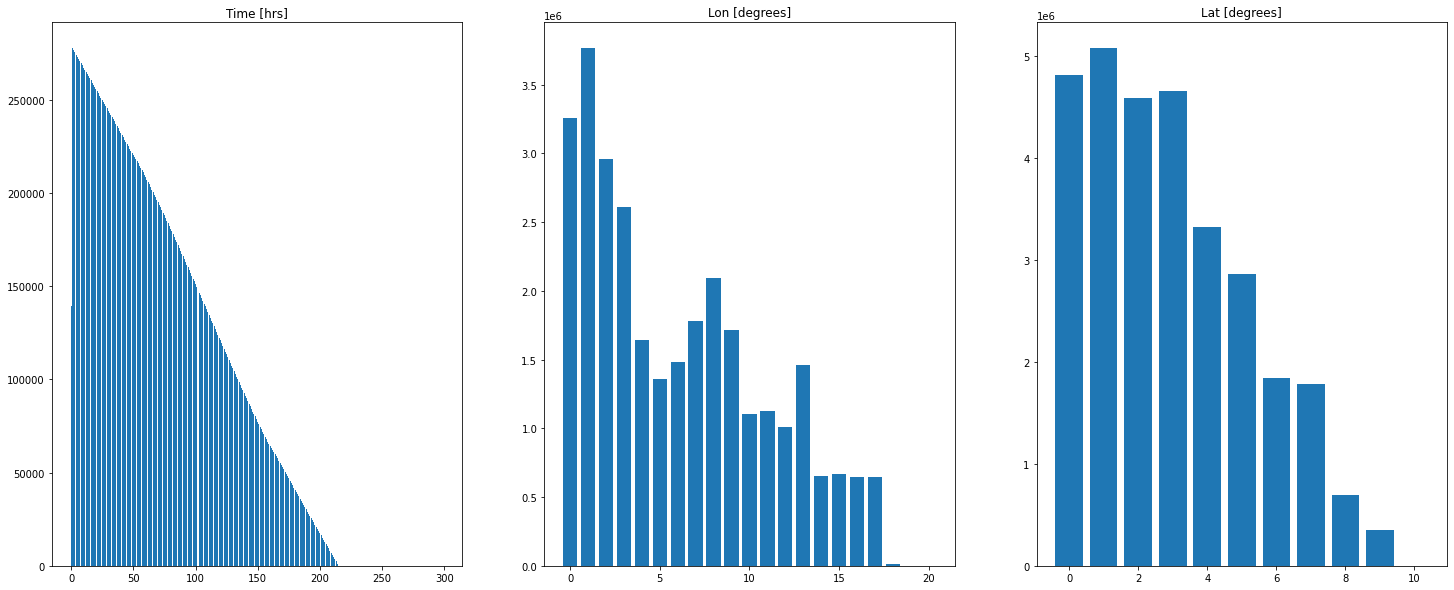

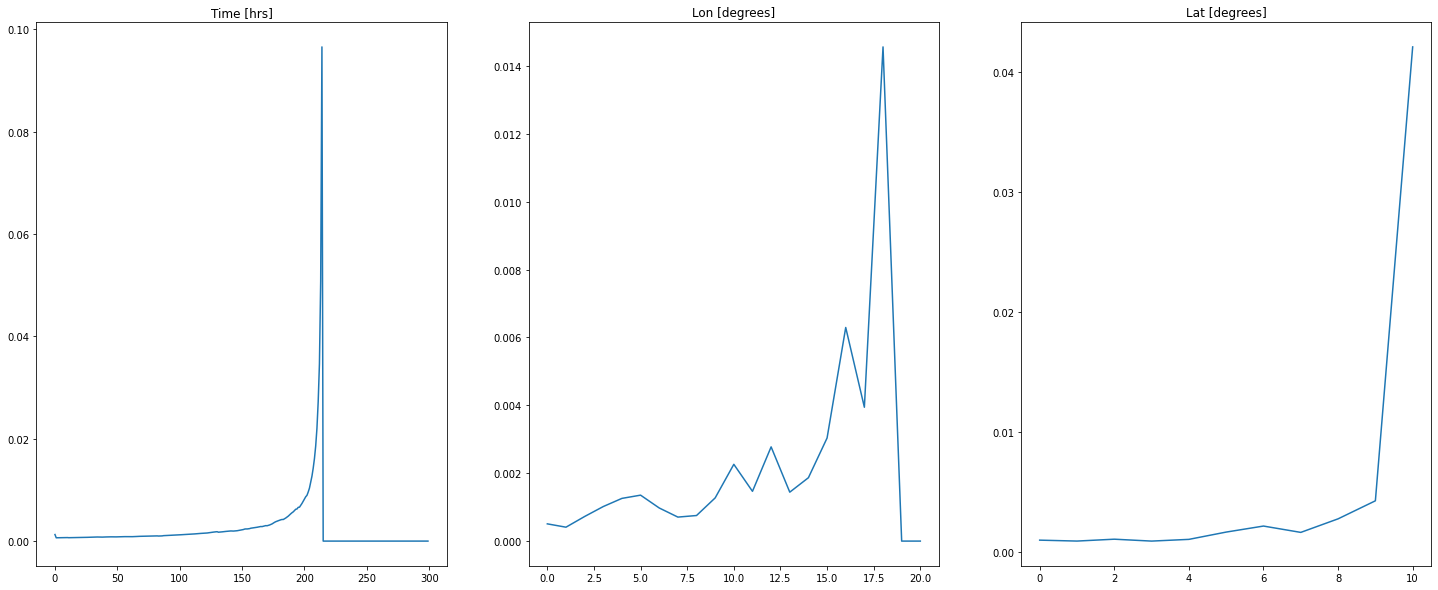

In [76]:
vario_ana.plot_histograms()
vario_ana.plot_variograms("v")

## Toy Example to test VariogramAnalysis class

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0 0 0 1 2 0] 6
[1 1 2 2 0 0] 6


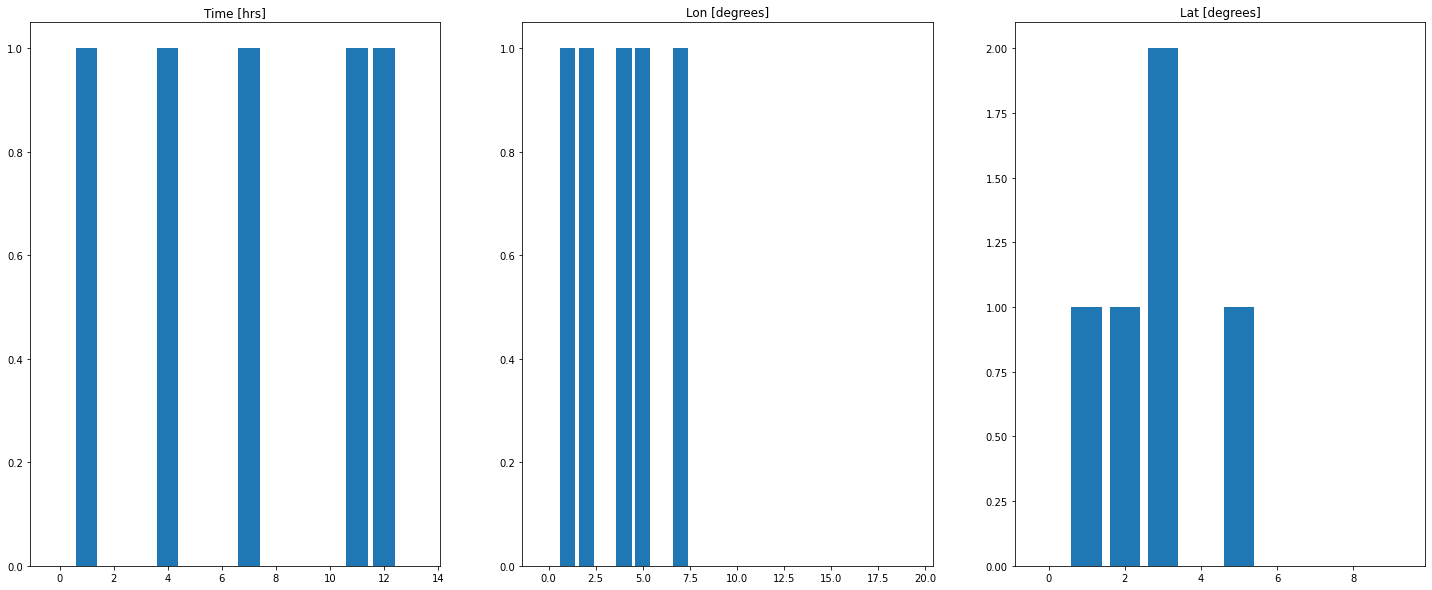

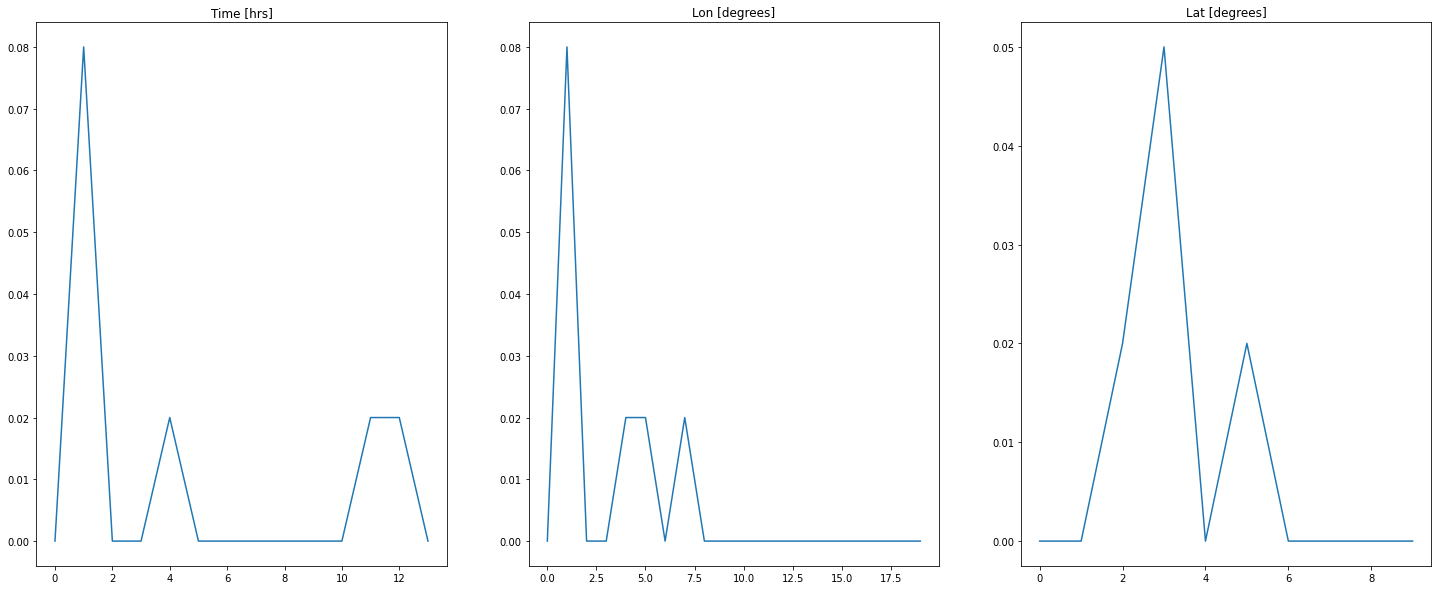

In [61]:
%load_ext autoreload
%autoreload 2

# Note for easier analysis comment out the division at the end of the function

from variogram.VariogramAnalysis import VariogramAnalysis

from datetime import datetime
import pandas as pd

# define toy values for all cols
time = [datetime(2022,5,5,13), datetime(2022,5,6,1), datetime(2022,5,5,14), datetime(2022,5,5,18)]
# t_lag = [12, 1, 5, 11, 7, 4]
lon = [-130.5, -124.6, -132.1, -127.3]
# lon_lag = [5, 1, 3, 7, 2, 4]
lat = [25.2, 27.6, 22.1, 25.8]
# lat_lag = [2, 3, 0, 5, 1, 3]
u_error = [0.3, 0.5, 0.7, 0.5]
# u_squared_diff = [0.04, 0.16, 0.04, 0.04, 0.0, 0.04]
v_error = [0.3, 0.7, 0.5, 0.5]
# v_squared_diff = [0.16, 0.04, 0.04, 0.04, 0.4, 0.0]
buoy = ["1", "2", "3", "1"]

# create dataset
toy_example = {"time":time, "lon":lon, "lat":lat, "u_error":u_error, "v_error":v_error, "buoy":buoy}
data = pd.DataFrame(toy_example)

vario_ana = VariogramAnalysis(data)
vario_ana.build_variogram_gen((1,1,1), (20,10,14), chunk_size=3, detrended=False, cross_buoy_pairs_only=False)
vario_ana.plot_histograms()
vario_ana.plot_variograms("u")

## Exploring detrending

In [13]:
%load_ext autoreload
%autoreload 2

from generative_model_metrics import calc_speed_mean, calc_speed_RMSE
from variogram.VariogramAnalysis import VariogramAnalysis
from Dataset import load_test_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

df = load_test_data()
# var_ana = VariogramAnalysis(df)
# var_ana.detrend(detrend_var="lat", num_bins=5)
# var_ana.plot_detrended_bins()
# var_ana.build_variogram((0.1,0.1,1), (200,100,240), chunk_size=int(1e6))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


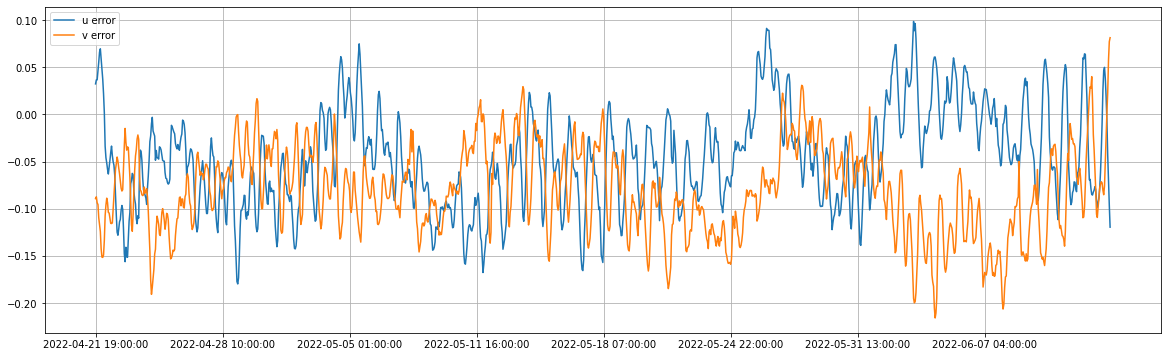

In [15]:
# plotting RMSE without detrending and binning
df["RMSE"] = np.sqrt(df["u_error"]**2 + df["v_error"]**2)

df_group = df.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
# plt.plot(df_group["time"], df_group["RMSE"], label="RMSE")
plt.plot(df_group["time"], df_group["u_error"], label="u error")
plt.plot(df_group["time"], df_group["v_error"], label="v error")
plt.xticks(np.arange(0, len(df_group), round(len(df_group)/8)))
plt.legend()
plt.grid()
plt.show()

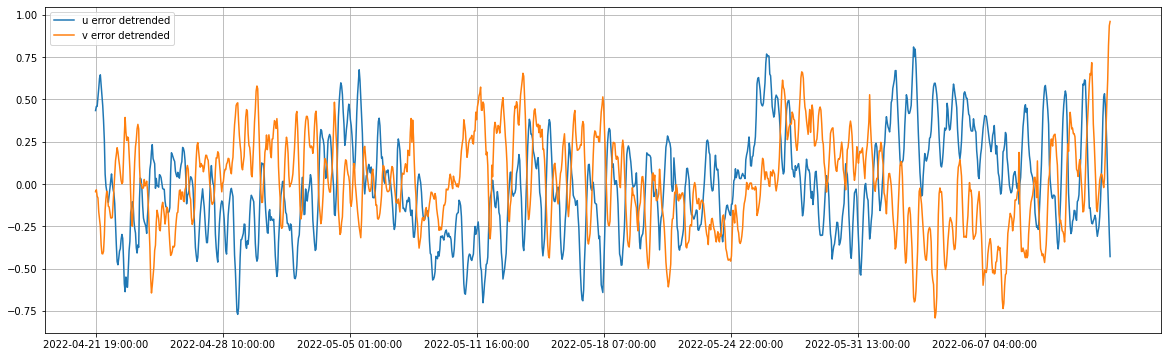

In [18]:
# detrend without splitting into bins
u_stats = [df["u_error"].mean(), np.sqrt(df["u_error"].var())]
v_stats = [df["v_error"].mean(), np.sqrt(df["v_error"].var())]
df["u_error_detrended"] = df.apply(lambda x: (x["u_error"] - u_stats[0])/u_stats[1], axis=1)
df["v_error_detrended"] = df.apply(lambda x: (x["v_error"] - v_stats[0])/v_stats[1], axis=1)

df["RMSE_detrended"] = np.sqrt(df["u_error_detrended"]**2 + df["v_error_detrended"]**2)

df_group = df.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
# plt.plot(df_group["time"], df_group["RMSE_detrended"], label="RMSE of detrended errors")
plt.plot(df_group["time"], df_group["u_error_detrended"], label="u error detrended")
plt.plot(df_group["time"], df_group["v_error_detrended"], label="v error detrended")
plt.xticks(np.arange(0, len(df_group), round(len(df_group)/8)))
plt.grid()
plt.legend()
plt.show()

In [19]:
# bin data in latitude and find mean and std
detrend_var = "lat"
num_bins = 5
min_val = np.floor(np.min(df[detrend_var].to_numpy()))
max_val = np.ceil(np.max(df[detrend_var].to_numpy()))
bins = np.arange(min_val, max_val+(max_val-min_val)/num_bins, (max_val-min_val)/num_bins)
# bin boundaries are not inclusive
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
df[f"{detrend_var}_bins"] = pd.cut(df[detrend_var], bins, labels=bin_labels, include_lowest=True)

# get bin statistics
bin_statistics = {}
for bin_label in bin_labels:
    u_stats = []
    u_stats.append(df[df[f"{detrend_var}_bins"] == bin_label]["u_error"].mean())
    u_stats.append(np.sqrt(df[df[f"{detrend_var}_bins"] == bin_label]["u_error"].var()))

    v_stats = []
    v_stats.append(df[df[f"{detrend_var}_bins"] == bin_label]["v_error"].mean())
    v_stats.append(np.sqrt(df[df[f"{detrend_var}_bins"] == bin_label]["v_error"].var()))

    bin_statistics[bin_label] = {"u_error": u_stats, "v_error": v_stats}

print(bin_statistics)

# subtract mean and divide by std with bin statistics
df["detrended_u_error"] = df.apply(lambda x: (x["u_error"] - bin_statistics[x[f"{detrend_var}_bins"]]["u_error"][0])\
    /bin_statistics[x[f"{detrend_var}_bins"]]["u_error"][1], axis=1)
df["detrended_v_error"] = df.apply(lambda x: (x["v_error"] - bin_statistics[x[f"{detrend_var}_bins"]]["v_error"][0]\
    )/bin_statistics[x[f"{detrend_var}_bins"]]["v_error"][1], axis=1)

{'20.0-22.0': {'u_error': [-0.08516014095083375, 0.16109805707763253], 'v_error': [-0.04075725291440432, 0.17987517529380398]}, '22.0-24.0': {'u_error': [-0.0875925009926102, 0.15757609731982394], 'v_error': [-0.0824361671014528, 0.150027005056675]}, '24.0-26.0': {'u_error': [-0.07876174338042989, 0.14432937124234407], 'v_error': [-0.07180257737659917, 0.1671813967173878]}, '26.0-28.0': {'u_error': [0.011119070975746229, 0.16138317856490103], 'v_error': [-0.1153996322356923, 0.1491022365801097]}, '28.0-30.0': {'u_error': [-0.028987960014146826, 0.20131035531570998], 'v_error': [-0.07936411138414311, 0.1839196288322338]}}


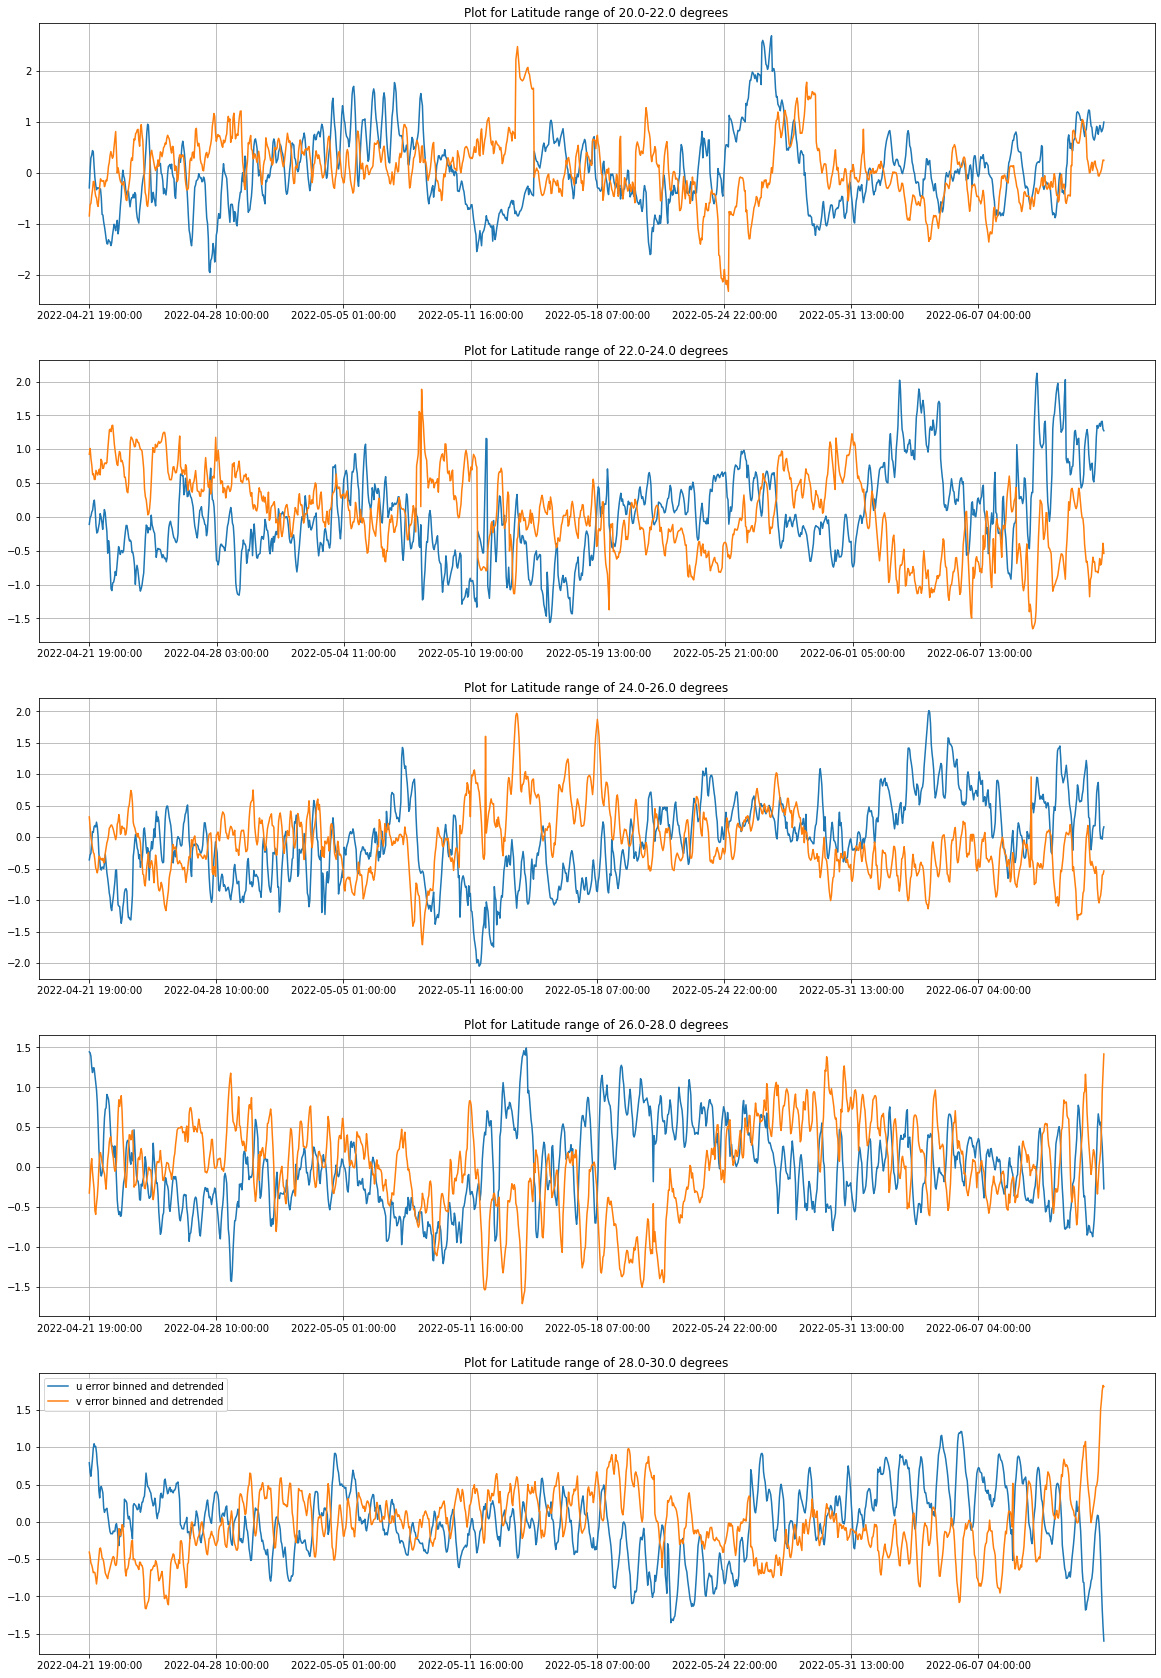

In [20]:
fig, axs = plt.subplots(len(bin_labels),1,figsize=(20,len(bin_labels)*6))

for i,bin_label in enumerate(bin_labels):
    detrended_u_error = df[df["lat_bins"] == bin_label]["detrended_u_error"].to_numpy()
    detrended_v_error = df[df["lat_bins"] == bin_label]["detrended_v_error"].to_numpy()
    detrended_RMSE = np.sqrt(detrended_u_error**2 + detrended_v_error**2)
    bin_time = df[df["lat_bins"] == bin_label]["time"]
    df_temp = pd.DataFrame({"time": bin_time, "detrended_RMSE": detrended_RMSE, "u_error_detrended": detrended_u_error,\
                            "v_error_detrended": detrended_v_error})
    detrended_group = df_temp.groupby(by=["time"], as_index=False).mean()
    # axs[i].plot(detrended_group["time"], detrended_group["detrended_RMSE"], label="RMSE binned and detrended")
    axs[i].plot(detrended_group["time"], detrended_group["u_error_detrended"], label="u error binned and detrended")
    axs[i].plot(detrended_group["time"], detrended_group["v_error_detrended"], label="v error binned and detrended")
    axs[i].title.set_text(f"Plot for Latitude range of {bin_label} degrees")
    axs[i].set_xticks(np.arange(0, len(detrended_group), round(len(detrended_group)/8)))
    axs[i].grid()
plt.legend()
plt.show()

# Using Geostatspy for 2D

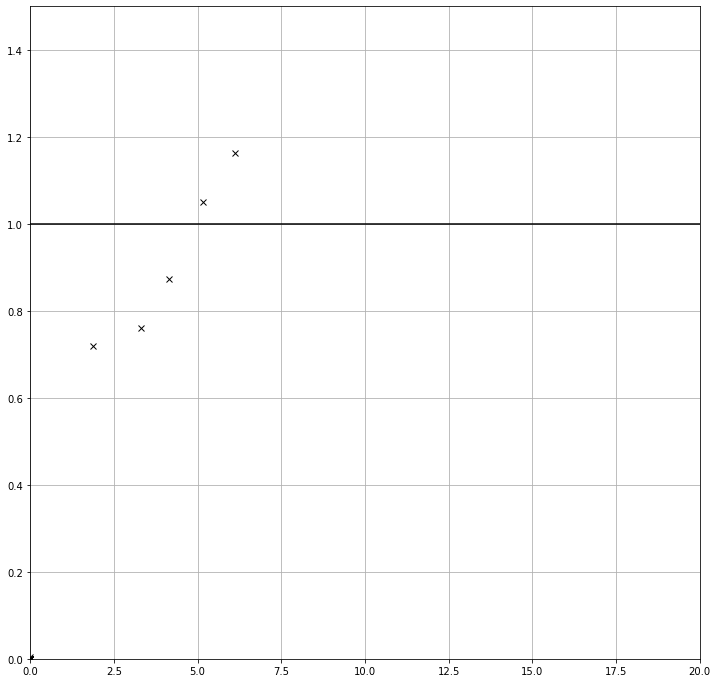

In [20]:
# set params
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 2.0; lag_tol = 4.0; nlag = 20;               # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0, 90]                                       # directions in azimuth to consider

lag, gamma, npp = geostats.gamv(
    data,
    "lon",
    "lat",
    "u_error",
    tmin,
    tmax,
    lag_dist,
    lag_tol,
    nlag,
    azi_mat[0],
    atol,
    bandh,
    isill
)

fig = plt.figure(figsize=(12,12))
plt.plot(lag, gamma, 'x', color = 'black')
plt.plot([0,20], [1.0, 1.0], color = 'black')
plt.xlim([0, 20])
plt.ylim([0, 1.5])
plt.grid(True)
plt.show()